# Univariate Time Series Model of Wind Generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from datetime import datetime, timedelta

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam


import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Guidance from https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

In [3]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/texas_temp.csv')

In [4]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [5]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [6]:
df = df[['date', 'NGas']]

df['date']=pd.to_datetime(df['date'])

df = df[df['date'].dt.day == 1]

df.reset_index(inplace=True)

df.drop(columns='index',inplace=True)

df_full = pd.concat([df, temp_df], axis =1)

In [7]:
df_full

,date,NGas,Date,Temp
0,2011-01-01,248086.363990,1/1/11,45.0
1,2011-02-01,218819.159530,2/1/11,48.7
2,2011-03-01,343441.973030,3/1/11,61.8
3,2011-04-01,202053.382820,4/1/11,70.3
4,2011-05-01,472446.061500,5/1/11,74.1
...,...,...,...,...
115,2020-08-01,721716.604984,8/1/20,84.3
116,2020-09-01,651271.628603,9/1/20,74.0
117,2020-10-01,445206.272739,10/1/20,65.9
118,2020-11-01,347772.901358,11/1/20,60.6


In [8]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

In [9]:
df_full

,NGas,Temp
date,,
2011-01-01,248086.363990,45.0
2011-02-01,218819.159530,48.7
2011-03-01,343441.973030,61.8
2011-04-01,202053.382820,70.3
2011-05-01,472446.061500,74.1
...,...,...
2020-08-01,721716.604984,84.3
2020-09-01,651271.628603,74.0
2020-10-01,445206.272739,65.9


In [10]:
X = df_full
y = df_full['NGas'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

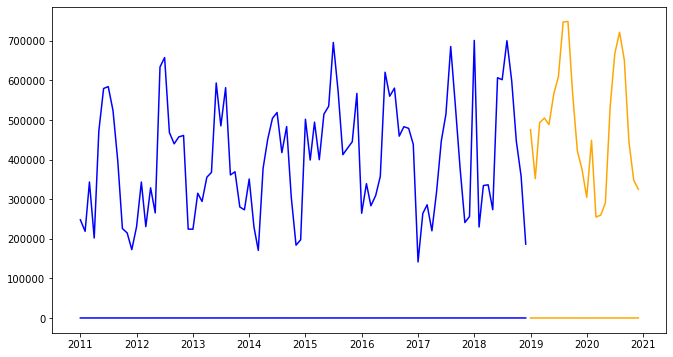

In [12]:
plt.figure(figsize =(11, 6))
plt.plot(X_train, c='blue')
plt.plot(X_test, c ='orange')

## Scaling

In [13]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Preprocessing

In [14]:
train_sequences = TimeseriesGenerator(data=X_train_sc, 
                                      targets=y_train, 
                                      length=12, 
                                      batch_size=64
                                     )

In [15]:
batch_x, batch_y = train_sequences[0]

In [16]:
batch_x.shape, batch_y.shape

((64, 12, 2), (64,))

In [17]:
batch_x

array([[[0.19033036, 0.02702703],
        [0.13801265, 0.11036036],
        [0.36078692, 0.40540541],
        ...,
        [0.15090455, 0.52027027],
        [0.13063971, 0.29504505],
        [0.05554524, 0.0518018 ]],

       [[0.13801265, 0.11036036],
        [0.36078692, 0.40540541],
        [0.10804234, 0.59684685],
        ...,
        [0.13063971, 0.29504505],
        [0.05554524, 0.0518018 ],
        [0.159132  , 0.14864865]],

       [[0.36078692, 0.40540541],
        [0.10804234, 0.59684685],
        [0.59139311, 0.68243243],
        ...,
        [0.05554524, 0.0518018 ],
        [0.159132  , 0.14864865],
        [0.36050573, 0.18018018]],

       ...,

       [[0.35327696, 0.23873874],
        [0.25346273, 0.39189189],
        [0.29969018, 0.50225225],
        ...,
        [0.60313573, 0.38738739],
        [0.53104766, 0.13063063],
        [0.        , 0.15765766]],

       [[0.25346273, 0.39189189],
        [0.29969018, 0.50225225],
        [0.38621518, 0.62612613],
        .

In [18]:
test_sequences = TimeseriesGenerator(data=X_test_sc, 
                                      targets=y_test, 
                                      length=12, 
                                      batch_size=64
                                     )

In [19]:
input_shape = train_sequences[0][0][0].shape

### Reshape our data

In [20]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, activation ='relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer= Adam(learning_rate=0.01), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [21]:
history= model.fit_generator(train_sequences, validation_data =test_sequences, epochs=150, verbose=0)

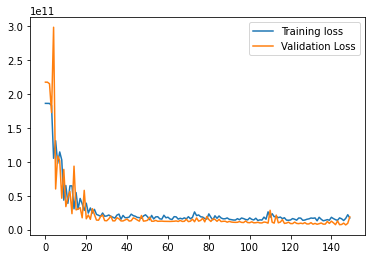

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [38]:
trainPredict = model.predict_generator(train_sequences)
testPredict = model.predict_generator(test_sequences)

In [34]:
trainPredict = trainPredict.flatten()
testPredict = testPredict.flatten()

In [37]:
testPredict.shape

(12, 1)

In [24]:
n_forecast = 24  # period length of forecasts - in this case, months


In [42]:
forecast = model.predict_generator(test_sequences[-n_forecast:])

TypeError: unsupported operand type(s) for *: 'int' and 'slice'

In [ ]:
n_input = 12
n_features = 1

pred_list = []

batch = X_train_sc[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(m.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [ ]:
n_forecast = 24  # period length of forecasts - in this case, months

# create a list of dates based on training dates, start at first training date and create list of length n_forecast
forecast_period_dates = pd.date_range(start=list(df_full.index)[-1], periods=n_forecast, freq='MS').tolist()   

In [ ]:
forecast_period_dates

In [ ]:
# make predictions on our model based on the training data. Use  
forecast = model.predict(train_sequences[0:][-n_forecast:])

In [ ]:
np.reshape(np.array(train_sequences[0]), [1,2])

In [ ]:
np.reshape(train_sequences, [1,2])